In [25]:
import pandas as pd
import numpy as np
import tqdm

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import spacy
from sklearn.utils import resample

import torch
from torchtext import data
from sklearn.metrics import f1_score
import pandas as pd 
import re
import random

import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import torch.optim as optim

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [27]:
raw_train_df = pd.read_csv("./data/train.csv")
raw_test_df = pd.read_csv("./data/test.csv")
raw_train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [28]:
del raw_train_df['keyword']
del raw_train_df['location']
del raw_train_df['id']

In [29]:
def text_cleaner(text):
    text = text.lower() # convert to lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # remove punctuation and special characters
    text = re.sub(r'\s+', ' ', text) # remove extra whitespace
    text = re.sub(r'https?://\S+', '', text) # remove URLs
    text = re.sub(r"#", "", text)
    return text

In [30]:
# Replaces the null values in the data with an empty string
train_data = raw_train_df.where((pd.notnull(raw_train_df)),'')
test_data = raw_test_df.where((pd.notnull(raw_test_df)),'')

train_data['text'] = train_data['text'].apply(text_cleaner)
test_data['text'] = test_data['text'].apply(text_cleaner)

In [31]:
# X=train_data['text'].apply(gensim.utils.simple_preprocess)
# Y = train_data['target']
# model.wv["holding"].shape

df_majority = train_data[train_data['target'] == 0]
df_minority = train_data[train_data['target'] == 1]

# Upsample the minority class
df_minority_upsampled = df_minority.sample(replace=True, n=len(df_majority), random_state=123)

# Combine the majority class and the upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Shuffle the rows of the new dataframe
train_data = df_upsampled.sample(frac=1).reset_index(drop=True)

X, Y = train_data['text'], train_data['target']

In [72]:
nlp = spacy.load('en_core_web_md')
X_vector = []
pbar = tqdm.trange(X.shape[0])
for t in pbar:
    doc = nlp(X[t])
    doc_tensor = []
    for i in range(len(doc)):
        word_tensor = torch.tensor(doc[i].vector)
        doc_tensor.append(word_tensor.reshape(1,len(word_tensor)))
    X_vector.append(doc_tensor)

100%|█████████████████████████████████████████████████████████████████████████████| 8684/8684 [00:46<00:00, 188.76it/s]


In [73]:
X_vector = np.array(X_vector)
X_train, X_test, Y_train, Y_test = train_test_split(X_vector, Y, test_size=0.2, random_state= 3)

print(Y_test)
Y_train = torch.from_numpy(Y_train.values)
Y_test = torch.from_numpy(Y_test.values)

Y_test = Y_test.view(Y_test.shape[0],1)
Y_train = Y_train.view(Y_train.shape[0],1)

print(X_train.shape, X_test.shape)

1064    0
3188    1
8262    1
8516    0
3384    0
       ..
491     1
3479    1
221     1
5915    0
4176    0
Name: target, Length: 1737, dtype: int64
(6947,) (1737,)


C:\Users\GHOSH\AppData\Local\Temp\ipykernel_20756\2935369227.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  X_vector = np.array(X_vector)
C:\Users\GHOSH\AppData\Local\Temp\ipykernel_20756\2935369227.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_vector = np.array(X_vector)


In [78]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_dims,  hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h_ = nn.Linear(input_size + hidden_size, hidden_dims)
        self.h_2h = nn.Linear(hidden_dims, hidden_size)
        self.i2h = nn.Linear(input_size + hidden_size, hidden_dims)
        self.h2o = nn.Linear(hidden_dims, output_size)
        self.softmax = nn.LogSoftmax(dim= 1)
        self.tanh = nn.Tanh()
        
    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        hidden1  = self.i2h_(combined)
        hidden = self.tanh(self.h_2h(hidden1))
        hidden2 = self.i2h(combined)
        output = self.softmax(self.h2o(hidden2))
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [79]:
# we will keep feeding the RNN one row at a time 
input_size = 300
n_hidden = 300
hidden_dims = 170

n_categories = 2
num_epochs = 2
learning_rate = 0.0005
all_losses = []

rnn = RNN(input_size, hidden_dims, n_hidden, n_categories)

criterion = nn.CrossEn
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

n_iters = 100000
current_loss = 0

plot_steps, print_steps = 1000, 1000

def category_from_output(output):
    category_index = torch.argmax(output).item()
    return category_index

for i in range(n_iters):
    hidden = rnn.init_hidden()
    index = random.randint(0, len(X_train) - 1)
    doc = X_train[index]
    for word_tensor in doc:
        output, hidden = rnn(word_tensor, hidden)
    loss = criterion(output, Y_train[index])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    current_loss += loss.item()
    
    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss/ plot_steps)
        current_loss = 0
        
    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "Correct" if guess == Y_train[index].item() else f"Wrong ({Y_train[index].item()})"
        print(f"{i+1} {(i+1)/n_iters*100} {loss:.4f} / {guess} {correct}")

1000 1.0 0.5296 / 1 Correct
2000 2.0 0.3774 / 1 Correct
3000 3.0 0.6954 / 0 Wrong (1)
4000 4.0 0.7565 / 1 Wrong (0)
5000 5.0 0.3691 / 1 Correct
6000 6.0 0.4608 / 0 Correct
7000 7.000000000000001 0.3097 / 0 Correct
8000 8.0 0.3434 / 1 Correct
9000 9.0 0.7538 / 0 Wrong (1)
10000 10.0 0.7641 / 1 Wrong (0)
11000 11.0 0.2849 / 0 Correct
12000 12.0 0.4447 / 0 Correct
13000 13.0 0.9756 / 0 Wrong (1)
14000 14.000000000000002 0.3376 / 0 Correct
15000 15.0 0.6704 / 1 Correct
16000 16.0 1.1032 / 1 Wrong (0)
17000 17.0 0.4096 / 0 Correct
18000 18.0 0.2597 / 1 Correct
19000 19.0 0.5567 / 1 Correct
20000 20.0 0.6768 / 1 Correct
21000 21.0 0.1070 / 1 Correct
22000 22.0 0.2226 / 1 Correct
23000 23.0 0.2496 / 1 Correct
24000 24.0 1.0011 / 0 Wrong (1)
25000 25.0 0.4332 / 1 Correct
26000 26.0 0.0864 / 1 Correct
27000 27.0 0.0577 / 0 Correct
28000 28.000000000000004 0.6647 / 0 Correct
29000 28.999999999999996 0.8205 / 1 Wrong (0)
30000 30.0 0.0843 / 1 Correct
31000 31.0 0.0907 / 1 Correct
32000 32.0 0.079

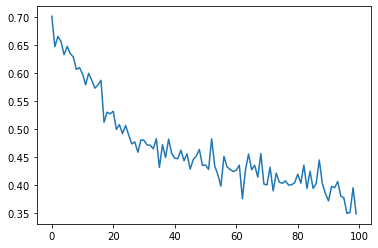

In [80]:
# print(all_losses)
plt.figure()
plt.plot(all_losses)
plt.show()

In [81]:
correct = 0
y_pred = []
y_true = []
for i , doc  in enumerate(X_test):
    hidden = rnn.init_hidden()
    for word_tensor in doc:
        output, hidden = rnn(word_tensor, hidden)
    guess  = category_from_output(output)
    y_pred.append(guess)
    y_true.append(Y_test[i].item())
    if guess == Y_test[i].item():
        correct += 1
print(correct/ Y_test.shape[0])

0.7904432930339667


In [82]:
from sklearn.metrics import precision_recall_fscore_support

def calculate_precision_recall(y_true, y_pred):
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    return precision, recall

precision, recall = calculate_precision_recall(y_true, y_pred)
print("Precision: ", precision)
print("Recall: ", recall)

Precision:  0.796960175087855
Recall:  0.7910740139691025
